## Aula 1 - NLP

Neste exercício faremos todos os pré-processamentos necessários para que sequências de textos possam ser interpretadas por Redes Neurais.

A tarefa que exploraremos é a Classificaćão de Sentimento usando um dataset de revisões de restaurantes (YELP), produtos (Amazon) e filmes (IMDB) [link](https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences).

A nossa tarefa consiste em analisar a revisão e classificá-la entre "positiva" ou "negativa".

Primeiramente, vamos explorar o dataset:

In [1]:
import tensorflow as tf
tf.__version__ #Talvez seja necessário instalar tensorflow 2 antes de iniciar esse notebook

'2.1.0'

Nosso dataset tem 3 colunas:

- sentence: O texto da revisão
- label: 1 para texto positivo e 0 para negativo
- source: yelp, amazon ou imdb


In [2]:
import pandas as pd
filepath_dict = {'yelp':   'data/sentiment/yelp_labelled.txt',
                 'amazon': 'data/sentiment/amazon_cells_labelled.txt',
                 'imdb':   'data/sentiment/imdb_labelled.txt'}

df_list = []
for source, filepath in filepath_dict.items():
    df = pd.read_csv(filepath, names=['sentence', 'label'], sep='\t')
    df['source'] = source  # Add another column filled with the source name
    df_list.append(df)

df = pd.concat(df_list)
df = df.sample(frac=1).reset_index(drop=True)
df.head()


,sentence,label,source
0,"This place is like Chipotle, but BETTER.",1,yelp
1,If you are Razr owner...you must have this!,1,amazon
2,The commercials are the most misleading.,0,amazon
3,"After one bite, I was hooked.",1,yelp
4,A lot of websites have been rating this a very...,1,amazon


Primeiramente, vamos separar nosso dataset de modo que 15% dele seja reservado para teste.

In [3]:
perc_train = 0.85
len_train = int(len(df)*perc_train)

dataset_train = df.iloc[0:len_train, :-1]
dataset_test = df.iloc[len_train:, :-1]

print(len(dataset_train))
print(len(dataset_test))

dataset_train.head()

2335
413


,sentence,label
0,"This place is like Chipotle, but BETTER.",1
1,If you are Razr owner...you must have this!,1
2,The commercials are the most misleading.,0
3,"After one bite, I was hooked.",1
4,A lot of websites have been rating this a very...,1


Agora que temos nosso dataset organizado, o primeiro passo é processar o texto para que seja legível por uma Rede Neural

O primeiro passo é gerar o vocabulário a partir da base de treinamento com a classe [Tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer).

Essa classe executa diversas rotinas de pré-processamento úteis, entre elas:

- Remover pontuacões.
- através do parâmetro `num_words`, permite limitar o tamanho do vocabulário, descartando palavras incomuns.
- Normaliza capitalizacao com `lower=True`

Porém, antes de utilizar a classe, vamos remover stopwords do texto.

Stopwords são palavras com serventia apenas sintática, isso é, são irrelevantes para classificar o "sentimento" da sentenca (leia mais sobre stopwords [aqui](https://demacdolincoln.github.io/anotacoes-nlp/posts/pre-processamento-de-textos/#id2)).

In [4]:
#Estamos adicionando stopwords manualmente aqui. Também é possível baixá-las do módulo nltk
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]


#Adicione seu código para Excluir todas as stopwords de todos os exemplos de treinamento
dataset_train.loc[:,'sentence'] = dataset_train.loc[:,'sentence'].apply(lambda x: ' '.join([item for item in x.split() if item not in stopwords]))
dataset_train.head()

,sentence,label
0,"This place like Chipotle, BETTER.",1
1,If Razr owner...you must this!,1
2,The commercials misleading.,0
3,"After one bite, I hooked.",1
4,A lot websites rating good phone I.,1


Agora podemos gerar o vocabulário e codificar as sentencas

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer

max_vocab_size = 500   #Tamanho máximo do vocabulário
oov_token = '<OOV>'   # Token usado caso alguma palavra não for encontrada no vocabulário

tokenizer = Tokenizer(num_words=max_vocab_size, lower=True, oov_token = oov_token)
tokenizer.fit_on_texts(dataset_train.loc[:, 'sentence'])

Através do atributo `word_index`, podemos consultar o vocabulário gerado. As primeiras palavras são as mais comuns.

Em seguida, codificamos o dataset de treinamento e de teste

In [6]:
vocab_size = len(tokenizer.word_index)
tokenizer.word_index

{'<OOV>': 1,
 'i': 2,
 'the': 3,
 'not': 4,
 'it': 5,
 'good': 6,
 'great': 7,
 'this': 8,
 'phone': 9,
 'movie': 10,
 'film': 11,
 'one': 12,
 '1': 13,
 'food': 14,
 'place': 15,
 'like': 16,
 'just': 17,
 'time': 18,
 '0': 19,
 'service': 20,
 'really': 21,
 'well': 22,
 'bad': 23,
 'no': 24,
 'best': 25,
 'also': 26,
 'will': 27,
 'even': 28,
 "don't": 29,
 'back': 30,
 'love': 31,
 'ever': 32,
 'go': 33,
 'quality': 34,
 'product': 35,
 'made': 36,
 "i've": 37,
 'can': 38,
 'nice': 39,
 'get': 40,
 'work': 41,
 'excellent': 42,
 'better': 43,
 "i'm": 44,
 'all': 45,
 "it's": 46,
 'works': 47,
 'very': 48,
 'much': 49,
 'never': 50,
 'recommend': 51,
 'think': 52,
 'way': 53,
 'if': 54,
 'use': 55,
 'battery': 56,
 'first': 57,
 'headset': 58,
 "didn't": 59,
 'and': 60,
 'sound': 61,
 'but': 62,
 'pretty': 63,
 'we': 64,
 'make': 65,
 'my': 66,
 'a': 67,
 '10': 68,
 'you': 69,
 'every': 70,
 'there': 71,
 '2': 72,
 'got': 73,
 'still': 74,
 'say': 75,
 'worst': 76,
 'now': 77,
 'eno

In [7]:
dataset_train_sequences = tokenizer.texts_to_sequences(dataset_train.loc[:,'sentence'])
dataset_test_sequences = tokenizer.texts_to_sequences(dataset_test.loc[:,'sentence'])
print(dataset_train_sequences[0:2])

[[8, 15, 16, 1, 43], [54, 1, 1, 69, 203, 8]]


O último passo de pré-processamento agora consiste em realizar o padding das sequências.

Para isso, utilizaremos a funcão [`pad_sequences`](https://keras.io/preprocessing/sequence/)

Os principais argumentos dessa funcão são:

- `maxlen`: tamanho da sequência a ser gerada.
- `padding`: 'pre' para adicionar zeros à esquerda e 'post' para adicionar zeros à direita.
- `truncating`: 'pre' para remover palavras no comeco da frase se for maior que o tamanho especificado, 'post' para remover do final

In [8]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

maxlen = 500  #Tamanho máximo da frase
padding_type = 'post'
truncating_type = 'post'

dataset_train_sequences = pad_sequences(dataset_train_sequences, maxlen = maxlen, padding=padding_type, truncating=truncating_type)
dataset_test_sequences = pad_sequences(dataset_test_sequences, maxlen = maxlen, padding=padding_type, truncating=truncating_type)

print(len(dataset_train_sequences[0]))
print(len(dataset_train_sequences[1]))
print(dataset_train_sequences)

500
500
[[  8  15  16 ...   0   0   0]
 [ 54   1   1 ...   0   0   0]
 [  3   1   1 ...   0   0   0]
 ...
 [345   1   0 ...   0   0   0]
 [155   1   1 ...   0   0   0]
 [  2 118  99 ...   0   0   0]]


Agora que as sentencas estão em um formato favorável, podemos treinar nosso modelo.

In [9]:
#Adicione a sua arquitetura, lembrando que a entrada tem tamanho maxlen e a saída 2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

print(dataset_train_sequences.shape)

embedding_dim = 8
#embedding_dim = int(maxlen * 0.8)

model = Sequential()
#Sua arquitetura

model.add(Embedding(vocab_size, embedding_dim, input_length = maxlen))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

# model.add(Dense(8, activation = "softmax", input_shape = (500,)))
# model.add(Dense(4, activation = "softmax"))
# model.add(Dense(1, activation = "sigmoid"))

(2335, 500)


In [10]:
from tensorflow import keras
# Defina aqui seu otimizador e sua loss
optimizer = "Adam"
opt = keras.optimizers.Adam(learning_rate = 0.001)
loss = "binary_crossentropy"

In [11]:
model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 8)            37760     
_________________________________________________________________
flatten (Flatten)            (None, 4000)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 4001      
Total params: 41,761
Trainable params: 41,761
Non-trainable params: 0
_________________________________________________________________


In [12]:
from tensorflow.keras.utils import to_categorical
num_epochs = 10

train_seqs = dataset_train_sequences
train_labels = np.array(dataset_train.loc[:, 'label'])
test_seqs = dataset_test_sequences
test_labels = np.array(dataset_test.loc[:, 'label'])

print(len(train_seqs))
print(len(train_labels))
print(len(test_seqs))
print(len(test_labels))

hist = model.fit(train_seqs,train_labels, epochs = num_epochs, validation_data=(test_seqs,test_labels), verbose=2 )

2335
2335
413
413
Train on 2335 samples, validate on 413 samples
Epoch 1/10
2335/2335 - 1s - loss: 0.6942 - accuracy: 0.5135 - val_loss: 0.6914 - val_accuracy: 0.5254
Epoch 2/10
2335/2335 - 0s - loss: 0.6891 - accuracy: 0.6266 - val_loss: 0.6899 - val_accuracy: 0.5448
Epoch 3/10
2335/2335 - 0s - loss: 0.6721 - accuracy: 0.6946 - val_loss: 0.6733 - val_accuracy: 0.6295
Epoch 4/10
2335/2335 - 0s - loss: 0.6320 - accuracy: 0.7957 - val_loss: 0.6389 - val_accuracy: 0.7094
Epoch 5/10
2335/2335 - 0s - loss: 0.5756 - accuracy: 0.8274 - val_loss: 0.6031 - val_accuracy: 0.7191
Epoch 6/10
2335/2335 - 0s - loss: 0.5186 - accuracy: 0.8398 - val_loss: 0.5695 - val_accuracy: 0.7264
Epoch 7/10
2335/2335 - 0s - loss: 0.4690 - accuracy: 0.8445 - val_loss: 0.5441 - val_accuracy: 0.7264
Epoch 8/10
2335/2335 - 0s - loss: 0.4303 - accuracy: 0.8527 - val_loss: 0.5282 - val_accuracy: 0.7433
Epoch 9/10
2335/2335 - 0s - loss: 0.3982 - accuracy: 0.8617 - val_loss: 0.5179 - val_accuracy: 0.7433
Epoch 10/10
2335/

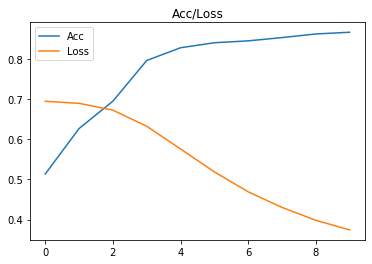

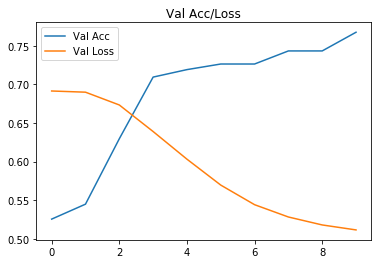

In [13]:
import matplotlib.pyplot as plt

plt.plot(hist.history["accuracy"], label='Acc')
plt.plot(hist.history["loss"], label='Loss')
plt.legend()
plt.title('Acc/Loss')
plt.show()

plt.plot(hist.history["val_accuracy"], label='Val Acc')
plt.plot(hist.history["val_loss"], label='Val Loss')
plt.legend()
plt.title('Val Acc/Loss')
plt.show()

Vamos verificar se as classificacões fazem sentido

In [14]:
or_test_sentences = ['very good movie', 'terrible taste', 'worst product ever']
#codificando
test_sentences = tokenizer.texts_to_sequences(or_test_sentences)
test_sentences = pad_sequences(test_sentences, maxlen = maxlen, padding=padding_type, truncating=truncating_type)

print(test_sentences)


[[ 48   6  10 ...   0   0   0]
 [ 96 280   0 ...   0   0   0]
 [ 76  35  32 ...   0   0   0]]


In [15]:
predictions = model.predict(test_sentences)
print(or_test_sentences)
print(predictions > 0.5)

['very good movie', 'terrible taste', 'worst product ever']
[[ True]
 [False]
 [False]]


Avalie como o número de dimensões do embedding, o tipo do padding, o tamanho do vocabulário, o tamanho máximo de sentenca, etc. contribuem para a qualidade do modelo.
